In [1]:
from pennylane import numpy as np
import torch
from torch import nn
import pennylane as qml
import matplotlib.pyplot as plt

import functools

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [2]:
def deterministic(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        torch.manual_seed(0)
        np.random.seed(0)
        value = func(*args, **kwargs)
        return value
    return wrapper

In [3]:
n_qubits = 1
dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
@deterministic
def circuit(inputs, w):
    qml.Rot(w[0, 0], w[0, 1], w[0, 2], wires=0)
    qml.RX(inputs[0], wires=0)
    qml.Rot(w[1, 0], w[1, 1], w[1, 2], wires=0)
    
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"w": (2, 3)}

print(qml.draw(circuit, decimals=2, expansion_strategy="device")(inputs=torch.arange(1), w=torch.rand(2, 3)))

0: ──Rot(0.50,0.77,0.09)──RX(0.00)──Rot(0.13,0.31,0.63)─┤  <Z>


In [50]:
class FreqNet(nn.Module):
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
    def forward(self, X):
        X = X.view(-1, 1)
        X = self.qlayer(X).view(-1, 1)
        return X

class FreqNetLin(nn.Module):
    @deterministic
    def __init__(self, circuit, weight_shapes):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        self.linear_in = nn.Linear(1, 1, bias=False)
        self.linear_in.weight = nn.Parameter(torch.tensor(2.0).view(-1, 1))
        #self.linear_out = nn.Linear(1, 1, bias=False)
    def forward(self, X):
        X = X.view(-1, 1)
        X = self.linear_in(X)
        X = self.qlayer(X).view(-1, 1)
        #X = self.linear_out(X)
        return X

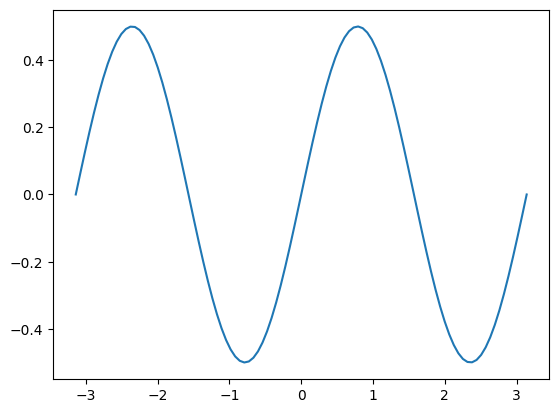

In [51]:
f = lambda x: 0.5 * np.sin(2*x)
x = np.linspace(-np.pi, np.pi, 100)
plt.plot(x, f(x))

In [52]:
def draw(net):
    y_exact = f(x)
    with torch.no_grad():
        X = torch.tensor(x, dtype=torch.float32)
        y_pred = net(X).numpy()
    
    plt.figure()
    plt.plot(x, y_exact, label="true")
    plt.plot(x, y_pred, label="pred")
    plt.legend()
    plt.show()

def train_adam(net, epochs=100):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    y_exact = torch.tensor(f(x), dtype=torch.float32)
    
    print("Started Adam training...")
    for e in range(epochs):
        optimizer.zero_grad()
        X = torch.tensor(x, dtype=torch.float32)
        y_pred = net(X).flatten()
        loss = criterion(y_exact, y_pred)
        loss.backward()
        optimizer.step()
    
        print(f"Epoch: {e}\t Loss: {loss.item()}")

def train_lbfgs(net, epochs=10):
    
    def closure():
        optimizer.zero_grad()
        y_pred = net(X)
        loss = criterion(y_exact, y_pred)
        loss.backward()
        return loss
        
    
    optimizer = torch.optim.LBFGS(net.parameters(), lr=0.1)
    criterion = nn.MSELoss()
    
    print("Started L-BFGS training...")
    for e in range(epochs):
        y_exact = torch.tensor(f(x), dtype=torch.float32)
        X = torch.tensor(x, dtype=torch.float32)
        l = optimizer.step(closure)
        
        print(f"Epoch: {e}\t Loss: {l.item()}")

In [53]:
net = FreqNetLin(circuit, weight_shapes)

In [56]:
net._modules["linear_in"].weight

Parameter containing:
tensor([[2.4485]], requires_grad=True)

In [55]:
train_lbfgs(net, epochs=50)

Started L-BFGS training...
Epoch: 0	 Loss: 0.49089497327804565
Epoch: 1	 Loss: 0.12817592918872833
Epoch: 2	 Loss: 0.12381624430418015
Epoch: 3	 Loss: 0.12375097721815109
Epoch: 4	 Loss: 0.12375004589557648
Epoch: 5	 Loss: 0.12375002354383469
Epoch: 6	 Loss: 0.12375002354383469


KeyboardInterrupt: 

In [23]:
train_adam(net, epochs=100)

Started Adam training...
Epoch: 0	 Loss: 0.43830856680870056
Epoch: 1	 Loss: 0.4222923517227173
Epoch: 2	 Loss: 0.4065842926502228
Epoch: 3	 Loss: 0.391221821308136
Epoch: 4	 Loss: 0.3762403428554535
Epoch: 5	 Loss: 0.3616730570793152
Epoch: 6	 Loss: 0.3475502133369446
Epoch: 7	 Loss: 0.333898663520813
Epoch: 8	 Loss: 0.32074177265167236
Epoch: 9	 Loss: 0.3080982267856598
Epoch: 10	 Loss: 0.29598191380500793
Epoch: 11	 Loss: 0.284401535987854
Epoch: 12	 Loss: 0.2733597457408905
Epoch: 13	 Loss: 0.26285281777381897
Epoch: 14	 Loss: 0.2528698742389679
Epoch: 15	 Loss: 0.24339333176612854
Epoch: 16	 Loss: 0.2343980073928833
Epoch: 17	 Loss: 0.22585196793079376
Epoch: 18	 Loss: 0.2177172303199768
Epoch: 19	 Loss: 0.2099504917860031
Epoch: 20	 Loss: 0.2025054395198822
Epoch: 21	 Loss: 0.19533436000347137
Epoch: 22	 Loss: 0.18839044868946075
Epoch: 23	 Loss: 0.18163053691387177
Epoch: 24	 Loss: 0.17501652240753174
Epoch: 25	 Loss: 0.16851697862148285
Epoch: 26	 Loss: 0.16210830211639404
Epoc

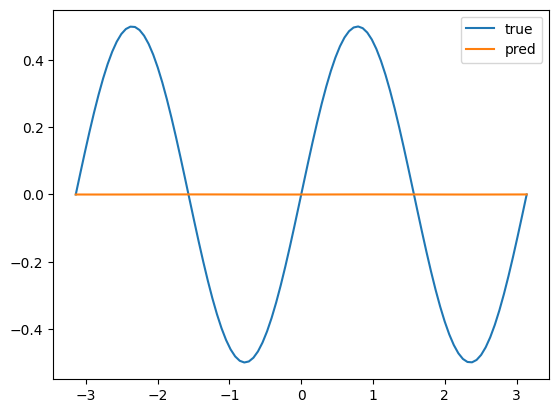

In [57]:
draw(net)

In [28]:
train_lbfgs(net, epochs=50)
torch.save(net.state_dict(), "models/lbfgs")

Started L-BFGS training...


/home/agse/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0	 Loss: 0.24757081034308093
Epoch: 1	 Loss: 0.22966396258273916
Epoch: 2	 Loss: 0.20038638715963447
Epoch: 3	 Loss: 0.18106481117711304
Epoch: 4	 Loss: 0.16793154985898187
Epoch: 5	 Loss: 0.15834550057297006
Epoch: 6	 Loss: 0.15109092881857158
Epoch: 7	 Loss: 0.14549033613295634
Epoch: 8	 Loss: 0.14111182406224212
Epoch: 9	 Loss: 0.13765903342622576
Epoch: 10	 Loss: 0.13491935637894245
Epoch: 11	 Loss: 0.13273564350789294
Epoch: 12	 Loss: 0.13098898724057356
Epoch: 13	 Loss: 0.1295882559817683
Epoch: 14	 Loss: 0.1284626454250264
Epoch: 15	 Loss: 0.12755666097143245
Epoch: 16	 Loss: 0.1268265253603347
Epoch: 17	 Loss: 0.12623752064951227
Epoch: 18	 Loss: 0.12576197420273455
Epoch: 19	 Loss: 0.12537780148696842
Epoch: 20	 Loss: 0.1250672681261259
Epoch: 21	 Loss: 0.12481617601618022
Epoch: 22	 Loss: 0.12461306784046441
Epoch: 23	 Loss: 0.12444874418494112
Epoch: 24	 Loss: 0.12431574817795797
Epoch: 25	 Loss: 0.12420811289662036
Epoch: 26	 Loss: 0.12412096875834479
Epoch: 27	 Loss

# Visualising loss landscape

In [2]:
from torch.nn.utils import (
    parameters_to_vector as Params2Vec,
    vector_to_parameters as Vec2Params
)